In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split


from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Fragments
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdFMCS
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, global_max_pool

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/u/shaswata/.local/lib/python3.9/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /u/shaswata/.local/lib/python3.9/site-packages/torch_scatter/_scatter_cpu.so: undefined symbol: _ZN5torch8autograd13_wrap_outputsERKSt6vectorIN2at6TensorESaIS3_EERKSt13unordered_setIPN3c1010TensorImplESt4hashISB_ESt8equal_toISB_ESaISB_EESJ_NS9_8ArrayRefINS9_8optionalIS3_EEEERKSt10shared_ptrINS0_4NodeEESt8functionIFS5_S5_S5_EE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/u/shaswata/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /u/shaswata/.local/lib/python3.9/site-packages/torch_cluster/_graclus_cpu.so: undefined symbol: _ZN2at4_ops8randperm4callElN3c108optionalINS2_10ScalarTypeEEENS3_INS2_6LayoutEEENS3_INS2_6DeviceEEENS3_IbEE
  warnings.warn(f"An issue occurred while importi

Using device: cuda


In [3]:
df = pd.read_csv('/u/shaswata/scratch/Learning/xAI_Drug/tox21.csv')
    
df = df.dropna(subset=['NR-AhR', 'smiles'])


In [4]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    atom_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic()),
            atom.GetNumRadicalElectrons(),
            atom.GetTotalNumHs()
        ]
        atom_features.append(features)
    
    edge_indices = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.extend([[i, j], [j, i]]) 
        
        bond_features = [
            int(bond.GetBondType()),
            int(bond.GetIsConjugated()),
            int(bond.IsInRing())
        ]
        edge_features.extend([bond_features, bond_features])
    
    x = torch.tensor(atom_features, dtype=torch.float)
    
    if edge_indices:
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.float)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 3), dtype=torch.float)  
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [5]:
graphs = []
labels = []
valid_smiles = []

for idx, row in df.iterrows():
    smiles = row['smiles']
    label = int(row['NR-AhR'])
    
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graphs.append(graph)
        labels.append(label)
        valid_smiles.append(smiles)

print(f"Successfully converted {len(graphs)} molecules to graphs")
print(f"Class distribution: {np.bincount(labels)}")

for i, graph in enumerate(graphs):
    graph.y = torch.tensor([labels[i]], dtype=torch.long)

train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42, 
                                           stratify=labels)

print(f"Training set size: {len(train_graphs)}")
print(f"Test set size: {len(test_graphs)}")

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

[09:48:59] WARNING: not removing hydrogen atom without neighbors
[09:49:00] Explicit valence for atom # 3 Al, 6, is greater than permitted
[09:49:00] Explicit valence for atom # 4 Al, 6, is greater than permitted
[09:49:00] Explicit valence for atom # 4 Al, 6, is greater than permitted
[09:49:01] Explicit valence for atom # 9 Al, 6, is greater than permitted
[09:49:01] Explicit valence for atom # 5 Al, 6, is greater than permitted
[09:49:01] Explicit valence for atom # 16 Al, 6, is greater than permitted
[09:49:01] Explicit valence for atom # 20 Al, 6, is greater than permitted


Successfully converted 6542 molecules to graphs
Class distribution: [5774  768]
Training set size: 5233
Test set size: 1309


/u/shaswata/.local/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
class MPNNLayer(MessagePassing):
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super(MPNNLayer, self).__init__(aggr='add')
        
        # Message function
        self.message_net = nn.Sequential(
            nn.Linear(2 * node_dim + edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.update_net = nn.Sequential(
            nn.Linear(node_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_dim)
        )
    
    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)
    
    def message(self, x_i, x_j, edge_attr):
        msg_input = torch.cat([x_i, x_j, edge_attr], dim=1)
        return self.message_net(msg_input)
    
    def update(self, aggr_out, x):
        update_input = torch.cat([x, aggr_out], dim=1)
        return self.update_net(update_input)

class MPNNModel(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, num_layers=3, num_classes=2):
        super(MPNNModel, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.node_embedding = nn.Linear(node_dim, hidden_dim)
        
        self.mpnn_layers = nn.ModuleList([
            MPNNLayer(hidden_dim, edge_dim, hidden_dim) 
            for _ in range(num_layers)
        ])
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),  # *2 for mean and max pooling
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        x = self.node_embedding(x)
        
        if edge_index.size(1) > 0:
            for layer in self.mpnn_layers:
                x = layer(x, edge_index, edge_attr)
                x = F.relu(x)
        else:
            x = F.relu(x)
        
        graph_mean = global_mean_pool(x, batch)
        graph_max = global_max_pool(x, batch)
        graph_repr = torch.cat([graph_mean, graph_max], dim=1)
        
        out = self.classifier(graph_repr)
        return out

node_dim = 7 
edge_dim = 3 
hidden_dim = 64

model = MPNNModel(node_dim, edge_dim, hidden_dim).to(device)


/u/shaswata/.local/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 000, Loss: 0.3816, Train Acc: 0.8827, Test Acc: 0.8824
Epoch 010, Loss: 0.2931, Train Acc: 0.8832, Test Acc: 0.8824
Epoch 020, Loss: 0.2564, Train Acc: 0.8947, Test Acc: 0.8992
Epoch 030, Loss: 0.2374, Train Acc: 0.9079, Test Acc: 0.8999
Epoch 040, Loss: 0.2116, Train Acc: 0.9213, Test Acc: 0.9152
Epoch 050, Loss: 0.1916, Train Acc: 0.9287, Test Acc: 0.9099
Epoch 060, Loss: 0.1734, Train Acc: 0.9388, Test Acc: 0.9083
Epoch 070, Loss: 0.1648, Train Acc: 0.9400, Test Acc: 0.9076
Epoch 080, Loss: 0.1486, Train Acc: 0.9465, Test Acc: 0.9030
Epoch 090, Loss: 0.1426, Train Acc: 0.9499, Test Acc: 0.9045
Epoch 100, Loss: 0.1348, Train Acc: 0.9524, Test Acc: 0.9076
Epoch 110, Loss: 0.1290, Train Acc: 0.9566, Test Acc: 0.9076
Epoch 120, Loss: 0.1259, Train Acc: 0.9570, Test Acc: 0.9060
Epoch 130, Loss: 0.1250, Train Acc: 0.9587, Test Acc: 0.9045
Epoch 140, Loss: 0.1225, Train Acc: 0.9603, Test Acc: 0.9037


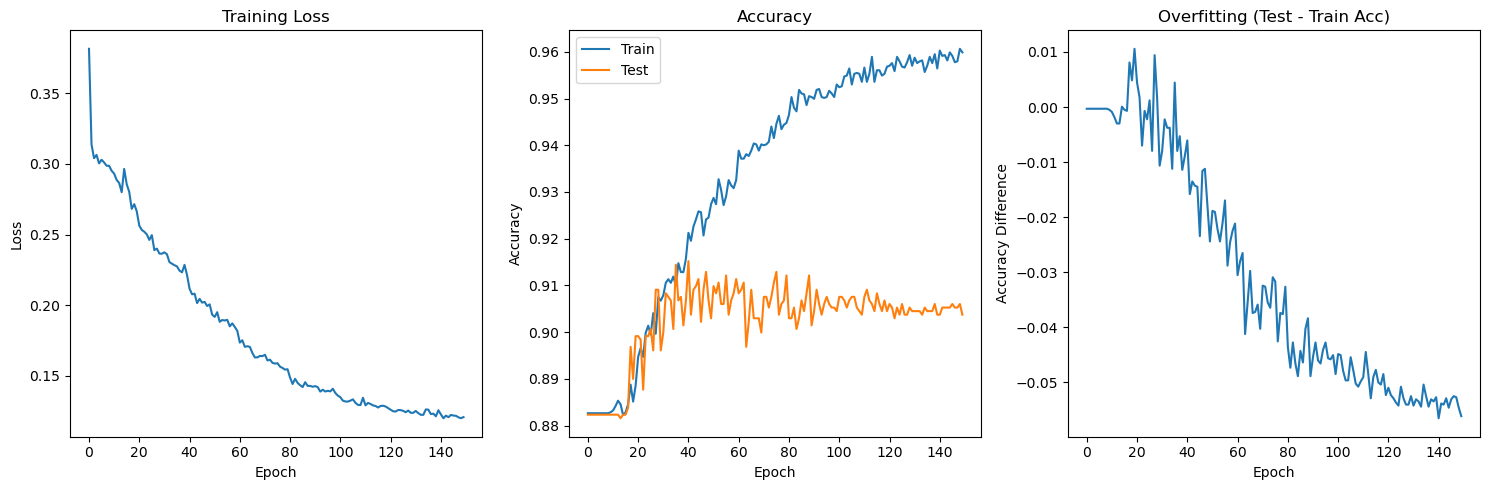

Final Train Accuracy: 0.9599
Final Test Accuracy: 0.9037


In [7]:
def train_model(model, train_loader, test_loader, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
    train_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
        
        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                out = model(batch)
                pred = out.argmax(dim=1)
                test_correct += (pred == batch.y).sum().item()
                test_total += batch.y.size(0)
        
        test_acc = test_correct / test_total
        
        train_losses.append(avg_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        scheduler.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    return train_losses, train_accs, test_accs

train_losses, train_accs, test_accs = train_model(model, train_loader, test_loader, num_epochs=150)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(np.array(test_accs) - np.array(train_accs))
plt.title('Overfitting (Test - Train Acc)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Difference')

plt.tight_layout()
plt.show()

print(f"Final Train Accuracy: {train_accs[-1]:.4f}")
print(f"Final Test Accuracy: {test_accs[-1]:.4f}")